# Defining a network
Describing our network to be run on the hardware (or the python simulator) is done using three data structures, corresponding to three dictionaries:
- config
- axons
- connections

In this notebook, we will setup the following example network with two axons, here named $\alpha$ and $\beta$, bringing in external inputs to a network of four neurons $a$, $b$, $c$, and $d$.


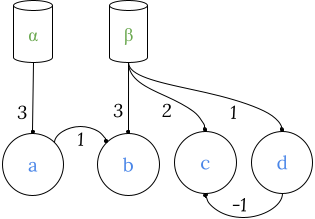

## Defining a configuration dictionary

The configuration dictionary specifies some properties that are shared by every neuron in the network:

| Parameter   | Description |
| :-          | :-          |
| neuron_type | the type of neuron model used to calculate membrane potentials. Possible assignments: |
| <ul><li>ANN</li></ul> | memoryless neuron (resets its membrane voltage to 0 with each step) |
| <ul><li>I&F</li></ul> | integrate and fire neuron |
| <ul><li>LI&F</li></ul> | leaky integrate and fire neuron: loses 1/8th of its membrane voltage with each step (can be updated on the FPGA) |
| global_neuron_params | a sub-dictionary of the configuration dictionary, contains: |
| <ul><li>v_thr</li></ul> | sets the membrane potential threshold for all neurons in the network |
| <ul><li>v_rst</li></ul> | the membrane potential the neuron resets to after firing, default 0. Note: this parameter is currently not user-writeable but can be made available as needed. |
| <ul><li>v_alpha</li></ul> | the amount of leak for the LI&F neuron, default 1/8th of the neuron's membrane potential. Note: this parameter is currently not user-writeable but can be made available as needed. |

In [1]:
config = {}
config['neuron_type'] = "I&F" # use integrate-and-fire neurons

config['global_neuron_params'] = {}
config['global_neuron_params']['v_thr'] = 4

# The following parameters are not exposed, but they can be as needed:
# config['global_neuron_params']['v_rst'] = 0 # this is to reset the neuron's membrane potential to some non-zero v_rst
# config['global_neuron_params']['v_alpha'] = 0 # this is only needed for leaky integrate-and-fire neurons

## Defining the axons dictionary
The axons dictionary configures inputs to the network. Axons are synapses to neurons in the network that the user can manually send spikes over at a given timestep. 

Below is a template for the axons dictionary:

```
axons = {
    'name of axon': [
        ('name of neuron', weight), 
        ('name of neuron', weight), 
        ...
    ],
    'name of axon': [
        ('name of neuron', weight), 
        ('name of neuron', weight), 
        ...
    ],
    ...
}
```

Each key in the dictionary is the name of an axon. 

Each value is a list of two-element tuples, where each tuple defines an in-going synapse to a neuron. The first element is the name of a neuron in the network and the second element is the weight of the synaptic connection. 

Synapse weights must be integers, but they may be positive or negative.

In [2]:
axons = {
    'alpha': [('a', 3)],
    'beta': [('b', 3), ('c', 2), ('d', 1)]
}

## Defining the connections dictionary
The connections dictionary defines the neurons in the network and the connections between them. 

Below is a template for the connections dictionary:

```
connections = {
    'name of pre-synaptic neuron': [
        ('name of post-synaptic neuron', weight), 
        ('name of post-synaptic neuron', weight), 
        ...
    ],
    'name of pre-synaptic neuron': [], # can be left empty
    ...
}
```

Each key in the dictionary is the name of a neuron. Note that the names of neurons in the connections dictionary and the names of axons in the axons dictionary must be mutually exclusive. 

Each value is a list of two element tuples. Each tuple defines a synapse between neurons in the network. The first element is the name of the postsynaptic neuron and the the second element is the weight of the synapse. 

Synapse weights must be integers but they may be positive or negative. 

If a neuron has no outgoing synapses it’s synapse list may be left empty.

In [3]:
connections = {
    'a': [('b', 1)],
    'b': [],
    'c': [],
    'd': [('c', -1)]
}

# Initializing a network
Once we’ve defined the above dictionaries we must pass them to the ```CRI_network``` constructor to create a ```CRI_network``` object.

In [4]:
# this notebook was launched from the /L2S/examples directory, but we need to import l2s from the parent directory
# one quick way is to add the parent directoy to path:
import sys
sys.path.append("../")

# now import the CRI_network class, used below for creating a network object using the dictionaries above
from l2s.api import CRI_network

hello, I got inited


In [5]:
network = CRI_network(
    axons=axons,
    connections=connections,
    config=config
)

moo


# Stepping through the simulation
Once we’ve constructed an CRI_network object we can run a timestep. We do so by calling the ```step()``` method of CRI_network. This method expects a single input called inputs. 

Inputs defines the inputs to the network at the current timestep as a list of axon names that you wish to carry spikes into the network at the current timestep. An empty list could be supplied if no external input is to be provided for a given step.

```step()``` outputs the membrane potential of each neuron in the network.

In [6]:
network.step(inputs=['alpha', 'beta'] ) # deliver a spike each over axons 'alpha' and 'beta'

{'membranePotentials': [('a', 3.0), ('b', 3.0), ('c', 2.0), ('d', 1.0)],
 'firedNeurons': []}

In [7]:
network.step() # no input

{'membranePotentials': [('a', 3.0), ('b', 3.0), ('c', 2.0), ('d', 1.0)],
 'firedNeurons': []}

In [8]:
network.step(['alpha']) 
# 'a' will have exceeded its threshold, but it fires at the next step.

{'membranePotentials': [('a', 6.0), ('b', 3.0), ('c', 2.0), ('d', 1.0)],
 'firedNeurons': []}

In [9]:
network.step([]) 
# 'a' has fired now, and it resets to v_rst = 0
# 'b' gets an input from 'a', and its now at its threshold too, but it must exceed its threshold to fire.

{'membranePotentials': [('a', 0.0), ('b', 4.0), ('c', 2.0), ('d', 1.0)],
 'firedNeurons': ['a']}

In [10]:
network.step(['beta']) 
# 'b' has exceeded its threshold

{'membranePotentials': [('a', 0.0), ('b', 7.0), ('c', 4.0), ('d', 2.0)],
 'firedNeurons': []}

In [11]:
network.step() 
# 'b' will have fired and reset now

{'membranePotentials': [('a', 0.0), ('b', 0.0), ('c', 4.0), ('d', 2.0)],
 'firedNeurons': ['b']}

In [12]:
network.step(['beta']) 
# 'c' is about to fire!

{'membranePotentials': [('a', 0.0), ('b', 3.0), ('c', 6.0), ('d', 3.0)],
 'firedNeurons': []}

In [13]:
network.step(['beta']) 
# 'b' is about to fire
# 'c' has fired and reset, and gotten a new input from 'beta'

{'membranePotentials': [('a', 0.0), ('b', 6.0), ('c', 2.0), ('d', 4.0)],
 'firedNeurons': ['c']}

In [14]:
network.step(['beta']) 
# 'b' has fired and reset, and gotten a new input from 'beta'
# 'c' is at its threshold, but needs to exceed its threshold to fire
# 'd' has exceeded its threshold, and will fire at the next step

{'membranePotentials': [('a', 0.0), ('b', 3.0), ('c', 4.0), ('d', 5.0)],
 'firedNeurons': ['b']}

In [15]:
network.step()
# 'c' has gotten a negative input from 'd'
# 'd' fired and reset

{'membranePotentials': [('a', 0.0), ('b', 3.0), ('c', 3.0), ('d', 0.0)],
 'firedNeurons': ['d']}

# Looping through the steps
We could run through the same inputs again but now in a loop. The idea is to still call the ```step()``` method for each input, but we could define inputs as an iterable (such as a dictionary) and call ```step(inputs[index])``` in a loop:

In [16]:
# The inputs can be defined using any iterable data structure.
# Here we illustrate this using a dictionary keyed by time-step:
inputs = {
    0: ['alpha', 'beta'],
    1: [],
    2: ['alpha'],
    3: [],
    4: ['beta'],
    5: [],
    6: ['beta'],
    7: ['beta'],
    8: ['beta'],
    9: [],
}

# number of simulation steps to run
duration = max(inputs.keys()) + 1 # add 1 for time step 0

# Re-instance the network (effectively resetting the state of all neurons)
network = CRI_network(
    axons=axons,
    connections=connections,
    config=config
)

# Define a data structure for collecting membrane voltage outputs from each step
outputs = {}
for t in range(duration):
    outputs[t] = network.step(inputs[t])
    
# Display the membrane potential of each neuron for each time step
outputs

moo


{0: {'membranePotentials': [('a', 3.0), ('b', 3.0), ('c', 2.0), ('d', 1.0)],
  'firedNeurons': []},
 1: {'membranePotentials': [('a', 3.0), ('b', 3.0), ('c', 2.0), ('d', 1.0)],
  'firedNeurons': []},
 2: {'membranePotentials': [('a', 6.0), ('b', 3.0), ('c', 2.0), ('d', 1.0)],
  'firedNeurons': []},
 3: {'membranePotentials': [('a', 0.0), ('b', 4.0), ('c', 2.0), ('d', 1.0)],
  'firedNeurons': ['a']},
 4: {'membranePotentials': [('a', 0.0), ('b', 7.0), ('c', 4.0), ('d', 2.0)],
  'firedNeurons': []},
 5: {'membranePotentials': [('a', 0.0), ('b', 0.0), ('c', 4.0), ('d', 2.0)],
  'firedNeurons': ['b']},
 6: {'membranePotentials': [('a', 0.0), ('b', 3.0), ('c', 6.0), ('d', 3.0)],
  'firedNeurons': []},
 7: {'membranePotentials': [('a', 0.0), ('b', 6.0), ('c', 2.0), ('d', 4.0)],
  'firedNeurons': ['c']},
 8: {'membranePotentials': [('a', 0.0), ('b', 3.0), ('c', 4.0), ('d', 5.0)],
  'firedNeurons': ['b']},
 9: {'membranePotentials': [('a', 0.0), ('b', 3.0), ('c', 3.0), ('d', 0.0)],
  'firedNeu

# Visualizing outputs
Here we provide some simple helper functions for visualizing the outputs of the small network in this example. This is only for pedagogical purposes, and other schemes could be used to handle outputs from large networks.

In [17]:
import matplotlib.pyplot as plt

def extractPotentials(outputs, makePlots=True):
    """
    Extract a time-series of membrane potentials for each neuron in outputs. Generate plots as needed.
    
    Parameters
    ----------
    outputs : dict
      Outputs dictionary containing membranePotentials and firedNeurons as returned by the python simulator. 
    makeplots : bool
      Set to true to generate plots of membranePotentials for each neuron using matplotlib.

    Returns
    -------
    voltageTraces : dict
      A dictionary with time series of membrane potentials for each neuron in outputs.
    """
    duration = max(inputs.keys())+1 # number of time steps in the trace
    
    voltageTraces = {} # empty container populated below with membrane potentials over time, keyed by neuron names
    for t in range(duration):
        for membranePotential in outputs[t]['membranePotentials']:
            neuron = membranePotential[0] # get the neuron name from the outputs['membranePotential'] tuple
            if not neuron in voltageTraces:
                voltageTraces[neuron] = [] # create an empty list to collect membrane voltages as the loop progresses
            voltageTraces[neuron].append(membranePotential[1]) # get the membrane voltage from the outputs['membranePotential'] tuple
    
    if makePlots:
        # plot the voltage trace for each neuron
        for neuron in voltageTraces.keys():
            plt.plot(voltageTraces[neuron], label=neuron)

        # plot a horizontal line corresponding to the threshold used
        plt.axhline(y=config['global_neuron_params']['v_thr'], c='r', ls='--', label='threshold')

        # plot formatting
        plt.legend()
        plt.xlim([0, duration])
        plt.xlabel('Step#')
        plt.ylabel('Membrane Potential')
        
    return voltageTraces

def extractSpikes(outputs, makePlots=True):
    duration = max(inputs.keys())+1 # number of time steps in the trace
    
    spikeTimes = {} # empty container populated below with membrane potentials over time, keyed by neuron names
    for t in range(duration):
        for spikes in outputs[t]['firedNeurons']:
            if spikes != []: # some neuron(s) spiked
                for neuron in spikes:
                    if not neuron in spikeTimes: # add the neuron to the dict of spikeTraces
                        spikeTimes[neuron] = [] # create an empty list to collect spike times for this neuron
                        
                    # now append the current time index to the neuron's spikes list:
                    spikeTimes[neuron].append(t) 
                    
    if makePlots:
        # plot the voltage trace for each neuron
        yOffset = 0
        for neuron in spikeTimes.keys():
            # make a spike raster for the selected neuron, keep colors consistent with key order
            plt.eventplot(spikeTimes[neuron], 
                          lineoffsets=yOffset, 
                          color=plt.rcParams['axes.prop_cycle'].by_key()['color'][yOffset],
                          label=neuron)
            yOffset += 1
            
        # plot formatting
        #plt.legend()
        plt.yticks(ticks=range(yOffset), labels=spikeTimes.keys())
        plt.xlim([0, duration])
        plt.xlabel('Step#')
        plt.ylabel('Spikes per neuron')
        
    return spikeTimes

{'a': [3.0, 3.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'b': [3.0, 3.0, 3.0, 4.0, 7.0, 0.0, 3.0, 6.0, 3.0, 3.0],
 'c': [2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 6.0, 2.0, 4.0, 3.0],
 'd': [1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 4.0, 5.0, 0.0]}

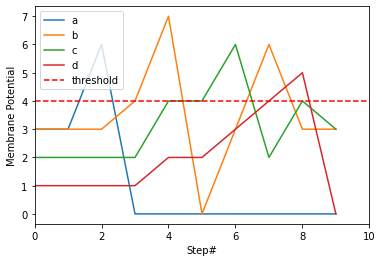

In [18]:
# We can reorganize the membrane potentials into a time-series of membrane potentials of each neuron.
voltageTraces = extractPotentials(outputs, makePlots=True)
voltageTraces # display the extracted time series of membrane voltages

{'a': [3], 'b': [5, 8], 'c': [7], 'd': [9]}

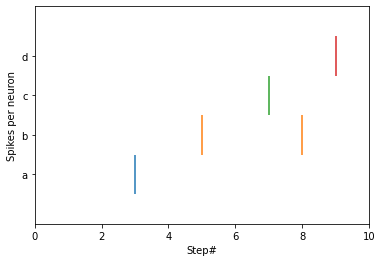

In [19]:
spikeTimes = extractSpikes(outputs, makePlots=True)
spikeTimes